In [1]:
!nvidia-smi

Wed Apr 15 22:32:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  N/A |
| 39%   61C    P0    40W / 180W |    960MiB / 16278MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os
import re
import tqdm
import random
import unicodedata
import numpy as np
import matplotlib.pyplot as plt

import spacy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Example, Field, Dataset
from torchtext.data.iterator import BucketIterator
from torchtext.data.metrics import bleu_score

In [3]:
seed = 781
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [4]:
def read_file(filepath):
    try:
        with open(filepath, mode='rt', encoding='utf-8') as file:
            content = file.readlines()
        return content
    except:
        raise Error(f'File {filepath} doesn\'t exist')

In [5]:
def unicode_to_ascii(s):
    # NFD => Normal Form Decompose
    # Mn => Non Marking Space
    return ''.join(c for c in unicodedata.normalize('NFD', s) \
                    if unicodedata.category(c) != 'Mn')

def normalize_string(s):
    # Transform accented characters into unaccented ones
    s = unicode_to_ascii(s.strip())
    # Replace any of '.', '!', '?' by ' .', ' !', ' ?'. \1 means the 1st bracked group. r is to not consider \1
    s = re.sub(r'([,.!?0-9])', r' \1', s)
    # Remove any character which is not in [^a-zA-Z0-9,.!?]
    s = re.sub(r'[^a-zA-Z0-9,.!?]', r' ', s)
    # Remove a sequence of whitespace characters
    s = re.sub(r'\s+', r' ', s)
    return s.strip()

In [6]:
%%time
pairs = [*zip(read_file('./data/europarl-v7.fr-en.fr'),
              read_file('./data/europarl-v7.fr-en.en'))]
pairs = [*map(lambda x: {'fr': x[0], 'en': x[1]}, pairs)]
print(f'Number of examples: {len(pairs):,}')

Number of examples: 2,007,723
CPU times: user 4.05 s, sys: 1.07 s, total: 5.11 s
Wall time: 5.11 s


In [7]:
%%time
pairs = np.random.choice(pairs, size=200000, replace=False)
pairs = [*map(lambda pair: {k: normalize_string(v) for k, v in pair.items()},
              pairs)]
print(f'Number of examples after sampling: {len(pairs):,}')
print(f'Example:\n\tFR => {pairs[0]["fr"]}\n\tEN => {pairs[0]["en"]}')

Number of examples after sampling: 200,000
Example:
	FR => Les procedures par le biais desquelles de tels produits entrent et sortent de l Union europeenne doivent etre ouvertes , transparentes et , par dessus tout , sures .
	EN => The procedures whereby such products come in and out of the European Union have to be open , transparent and , above all , safe .
CPU times: user 34.9 s, sys: 95.6 ms, total: 35 s
Wall time: 35 s


In [8]:
FR = Field(init_token='<sos>',
           eos_token='<eos>',
           preprocessing=lambda x: x[::-1],
           lower=True,
           tokenize='spacy',
           tokenizer_language='fr',
           include_lengths=True) # For pack_padded_sequence
EN = Field(init_token='<sos>',
           eos_token='<eos>',
           lower=True,
           tokenize='spacy',
           tokenizer_language='en')

MAX_LENGTH = 20

examples = [Example.fromdict(data=pair, fields={'fr': ('src', FR),
                                                'en': ('dest', EN)})
            for pair in tqdm.tqdm(pairs)]
examples = [*filter(lambda example: len(example.src) <= MAX_LENGTH and len(example.dest) <= MAX_LENGTH, examples)]
print(f'Number of examples after filtering: {len(examples):,}')

100%|██████████| 200000/200000 [01:26<00:00, 2313.56it/s]


Number of examples after filtering: 61,154


In [9]:
data = Dataset(examples, fields={'src': FR, 'dest': EN})
train_data, valid_data, test_data = data.split(split_ratio=[0.8, 0.1, 0.1])
print(f'train set size: {len(train_data.examples)}')
print(f'valid set size: {len(valid_data.examples)}')
print(f'test set size: {len(test_data.examples)}')
print(vars(train_data.examples[0]))

train set size: 48923
valid set size: 6116
test set size: 6115
{'src': ['.', 'crees', 'seront', 'emplois', 'nouveaux', 'de', ',', 'seulement', 'alors', 'et', ',', 'alors'], 'dest': ['then', 'and', 'only', 'then', 'will', 'new', 'jobs', 'be', 'created', '.']}


In [10]:
%%time
MIN_COUNT = 5
FR.build_vocab(train_data,
               min_freq=MIN_COUNT,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])
EN.build_vocab(train_data,
               min_freq=MIN_COUNT,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])

print(f'Length of FR vocabulary: {len(FR.vocab):,}')
print(f'Length of EN vocabulary: {len(EN.vocab):,}')

Length of FR vocabulary: 6,589
Length of EN vocabulary: 5,596
CPU times: user 929 ms, sys: 4.2 ms, total: 933 ms
Wall time: 932 ms


In [11]:
class Encoder(nn.Module):
    
    def __init__(self, embedding_size, vocab_size, hidden_size, n_layers, dropout, recurrent_dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embedding_size, hidden_size,
                            num_layers=n_layers, bidirectional=True,
                            dropout=(recurrent_dropout if n_layers > 1 else 0))
        self.fc = nn.Linear(hidden_size * 2, hidden_size)
        
    def forward(self, input_sequences, sequence_lengths):
        """
        :params
            input_sequences: Tensor[seq_len, batch_size]
            sequence_lengths: Tensor[batch_size,]
            
        :return
            outputs: Tensor[seq_len, batch_size, hidden_size]
            hn: Tensor[num_layers, batch_size, hidden_size]
            cn: Tensor[num_layers, batch_size, hidden_size]
        """
        embedded = self.embedding(input_sequences)
        embedded = self.dropout(embedded)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, sequence_lengths)
        outputs, (hn, cn) = self.lstm(packed)
        # hn, cn: [num_layers * 2, batch_size, hidden_size]
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # outputs: [seq_len, batch_size, hidden_size * 2]
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, :, self.hidden_size:]
        
        hn = torch.cat((hn[:self.n_layers, :, :], hn[self.n_layers:, :, :]), dim=2)
        cn = torch.cat((cn[:self.n_layers, :, :], cn[self.n_layers:, :, :]), dim=2)
        hn = torch.tanh(self.fc(hn))
        cn = torch.tanh(self.fc(cn))
        return outputs, hn, cn

In [12]:
class Decoder(nn.Module):

    def __init__(self, embedding_size, vocab_size, hidden_size, n_layers, dropout, recurrent_dropout):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embedding_size + hidden_size, hidden_size,
                            num_layers=n_layers,
                            dropout=(recurrent_dropout if n_layers > 1 else 0))
        self.fc = nn.Linear(embedding_size + hidden_size * 2, vocab_size)
        
    def forward(self, input_word_index, h_state, c_state, context):
        """
        :params
            input_word_index: Tensor[batch_size,]
            h_state: Tensor[n_layers, batch_size, hidden_size]
            c_state: Tensor[n_layers, batch_size, hidden_size]
            context: Tensor[1, batch_size, hidden_size]
            
        :return
            logit: Tensor[batch_size, vocab_size]
            h_state: Tensor[n_layers, batch_size, hidden_size]
            c_state: Tensor[n_layers, batch_size, hidden_size]
        """
        embedded = self.embedding(input_word_index.unsqueeze(0))
        embedded = self.dropout(embedded)
        # embedded: [1, batch_size, embedding_size]
            
        new_input = torch.cat((embedded, context), dim=2)
        # new_input: [1, batch_size, embedding_size + hidden_size]
        
        outputs, (h_state, c_state) = self.lstm(new_input, (h_state, c_state))
        # outputs: [1, batch_size, hidden_size]
        
        new_outputs = torch.cat((embedded, outputs, context), dim=2)
        # new_outputs: [1, batch_size, embedding_size + hidden_size * 2]
        
        logit = self.fc(new_outputs.squeeze(0))
        return logit, h_state, c_state

In [13]:
class SeqToSeqNet(nn.Module):

    def __init__(self, encoder, decoder, device):
        assert encoder.n_layers == decoder.n_layers, 'Encoder and Decoder must have the same number of reccurent layers'
        assert encoder.hidden_size == decoder.hidden_size, 'Encoder and Decoder must have the same number of reccurrent hidden units'

        super(SeqToSeqNet, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, input_sequences, sequence_lengths, target_sequences, tf_ratio):
        """
        :params
            input_sequences: Tensor[seq_len, batch_size]
            sequence_lengths: Tensor[batch_size,]
            target_sequences: Tensor[seq_len, batch_size]
            tf_ratio: float
            
        :return
            outputs: Tensor[seq_len - 1, batch_size, vocab_size]
                Since we ignore the SOS_TOKEN
        """
        _, h_state, c_state = self.encoder(input_sequences, sequence_lengths)
        
        seq_len, batch_size = target_sequences.size()
        outputs = torch.zeros(seq_len - 1, batch_size, self.decoder.vocab_size).to(self.device)
        word_index = target_sequences[0, :]
        context = h_state
        if self.decoder.n_layers > 1:
            context = context.sum(dim=0).unsqueeze(0)
            # context: [1, batch_size, hidden_size]
        
        
        for t, idx in enumerate(range(1, seq_len)):
            output, h_state, c_state = self.decoder(word_index, h_state, c_state, context)
            # output: [batch_size, vocab_size]
            outputs[t] = output
            
            if random.random() < tf_ratio:
                word_index = target_sequences[idx, :]
            else:
                word_index = output.argmax(dim=1)
                
        return outputs

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [15]:
def train_epoch(model, opt, loss_func, tf_ratio, data_it, grad_clip, epoch_text):
    epoch_loss = 0.
    pbar = tqdm.tqdm(enumerate(data_it), total=len(data_it))
    model.train()
    for i, data in pbar:
        opt.zero_grad()
        outputs = model(*data.src, data.dest, tf_ratio)
        # *data.src: unpack input_sequences and sequence_lengths
        loss = loss_func(outputs.view(-1, model.decoder.vocab_size), data.dest[1:].view(-1))
        loss.backward()
        # plot_gradient_flow(model.named_parameters())
        if grad_clip:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        opt.step()
        epoch_loss += loss.item()
        pbar.set_description(epoch_text + f'loss:     {epoch_loss / (i + 1):.3f} - ppl:     {np.exp(epoch_loss / (i + 1)):7.3f}')
    # plt.show() # Show the gradient flow
    return epoch_loss / len(data_it), np.exp(epoch_loss / len(data_it))

In [16]:
def valid_epoch(model, loss_func, data_it, epoch_text):
    epoch_loss = 0.
    pbar = tqdm.tqdm(enumerate(data_it), total=len(data_it))
    model.eval()
    with torch.no_grad():
        for i, data in pbar:
            outputs = model(*data.src, data.dest, 0) # Turn-off the teacher forcing
            loss = loss_func(outputs.view(-1, model.decoder.vocab_size), data.dest[1:].view(-1))
            epoch_loss += loss.item()
            pbar.set_description(epoch_text + f'val_loss: {epoch_loss / (i + 1):.3f} - val_ppl: {np.exp(epoch_loss / (i + 1)):7.3f}')
    return epoch_loss / len(data_it), np.exp(epoch_loss / len(data_it))

In [17]:
def train(model, opt, loss_func, train_it, valid_it, tf_ratio, n_epochs, grad_clip, save_to, filename):
    assert callable(loss_func)
    if not os.path.exists(save_to):
        !mkdir {save_to}
    
    history = {
        'loss': [],
        'val_loss': [],
        'ppl': [],
        'val_ppl': []
    }
    best_loss = [float('inf')]
    for epoch in range(n_epochs):
        epoch_text = f'Epoch: {epoch + 1:02d} - '
        loss, ppl = train_epoch(model=model, opt=opt, loss_func=loss_func, tf_ratio=tf_ratio,
                                data_it=train_it, grad_clip=grad_clip, epoch_text=epoch_text)
        val_loss, val_ppl = valid_epoch(model=model, loss_func=loss_func, data_it=valid_it, epoch_text=epoch_text)
        
        history['loss'].append(loss)
        history['val_loss'].append(val_loss)
        history['ppl'].append(ppl)
        history['val_ppl'].append(val_ppl)
        
        # Reduce tf_ratio
        tf_ratio = tf_ratio - tf_ratio / (epoch + 2)
        
        # Saving
        if val_loss < best_loss[-1]:
            best_loss.append(val_loss)
            torch.save({
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': opt.state_dict()
            }, f=os.path.join(save_to, filename))
            
        # Stop training
        try:
            if val_loss > best_loss[-2]:
                print('Stop training because the loss is increasing!')
                break
        except IndexError:
            pass
        
    return history

In [32]:
EMBEDDING_DIM = 128
HIDDEN_SIZE = 256
N_LAYERS = 1
DROPOUT = 0.25
RECURRENT_DROPOUT = 0.35
GRAD_CLIP = 1.0
BATCH_SIZE = 64
N_EPOCHS = 15
TF_RATIO = 0.5

In [33]:
train_iterator, valid_iterator, test_iterator =  \
        BucketIterator.splits((train_data, valid_data, test_data),
                              batch_size=BATCH_SIZE,
                              sort_key=lambda x: len(x.src),
                              sort_within_batch=True, # For pack_padded_sequence
                              device=device)

In [34]:
encoder = Encoder(embedding_size=EMBEDDING_DIM,
                  vocab_size=len(FR.vocab),
                  hidden_size=HIDDEN_SIZE,
                  n_layers=N_LAYERS,
                  dropout=DROPOUT,
                  recurrent_dropout=RECURRENT_DROPOUT).to(device)
decoder = Decoder(embedding_size=EMBEDDING_DIM,
                  vocab_size=len(EN.vocab),
                  hidden_size=HIDDEN_SIZE,
                  n_layers=N_LAYERS,
                  dropout=DROPOUT,
                  recurrent_dropout=RECURRENT_DROPOUT).to(device)
seq2seq = SeqToSeqNet(encoder=encoder,
                      decoder=decoder,
                      device=device).to(device)
opt_adam = optim.Adam(seq2seq.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=EN.vocab.stoi[EN.pad_token])
print(f'Number of parameters of the model: {count_parameters(seq2seq):,}')

Number of parameters of the model: 6,725,980


In [35]:
%%time
history = train(model=seq2seq,
                opt=opt_adam,
                loss_func=criterion,
                train_it=train_iterator,
                valid_it=valid_iterator,
                tf_ratio=TF_RATIO,
                n_epochs=N_EPOCHS,
                grad_clip=GRAD_CLIP,
                save_to='./saved_models',
                filename='seq2seq-baseline-bilstm.pt')

Epoch: 12 - val_loss: 3.959 - val_ppl:  52.405: 100%|██████████| 96/96 [00:02<00:00, 33.32it/s]

Stop training because the loss is increasing!
CPU times: user 14min 20s, sys: 22.9 s, total: 14min 43s
Wall time: 9min 51s


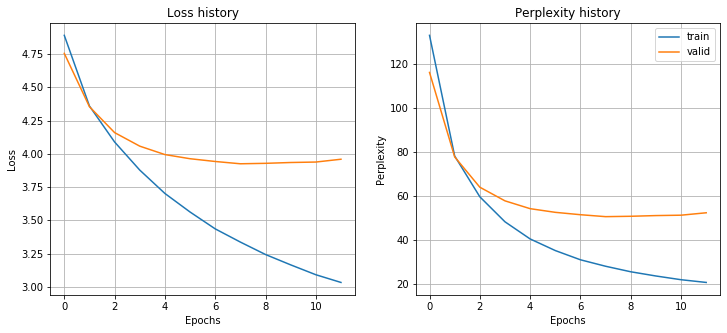

In [36]:
_, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(history['loss'], label='train')
axes[0].plot(history['val_loss'], label='valid')
axes[0].set_title('Loss history')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[1].plot(history['ppl'], label='train')
axes[1].plot(history['val_ppl'], label='valid')
axes[1].set_title('Perplexity history')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Perplexity')
axes[1].grid(True)
plt.legend()
plt.show()

In [38]:
seq2seq.load_state_dict(torch.load('./saved_models/seq2seq-baseline-bilstm.pt').get('model'))

<All keys matched successfully>

In [39]:
val_loss, val_ppl = valid_epoch(model=seq2seq,
                                loss_func=criterion,
                                data_it=test_iterator,
                                epoch_text='Evaluation on test set - ')

Evaluation on test set - val_loss: 3.954 - val_ppl:  52.151: 100%|██████████| 96/96 [00:02<00:00, 32.33it/s]


In [43]:
class Inference:
    
    def __init__(self, model, src_field, dest_field, normalizer, max_length, device):
        assert callable(normalizer)
        
        self.model = model
        self.src_field = src_field
        self.dest_field = dest_field
        self.normalizer = normalizer
        self.max_length = max_length
        self.device = device
    
    def encode(self, sentence):
        sentence = self.normalizer(sentence)
        sentence = self.src_field.preprocess(sentence)
        input_sequence, sequence_length = self.src_field.process([sentence])
        input_sequence = input_sequence.to(self.device)
        sequence_length = sequence_length.to(self.device)
        _, h_state, c_state = self.model.encoder(input_sequence, sequence_length)
        return _, h_state, c_state
    
    def greedy(self, sentence):
        """
        Translate using Greedy method
        
        :param
            sentence: str
            
        :return 
        """
        _, h_state, c_state = self.encode(sentence)
        context = h_state
        if self.model.decoder.n_layers > 1:
            context = context.sum(dim=0).unsqueeze(0)
            # context: [1, batch_size, hidden_size]
        outputs, logp = [], 0
        word_index = torch.tensor([self.dest_field.vocab.stoi[self.dest_field.init_token]], device=self.device)
        for _ in range(self.max_length):
            output, h_state, c_state = self.model.decoder(word_index, h_state, c_state, context)
            probas = F.softmax(output, dim=1)
            proba, word_index = torch.topk(probas, k=1, dim=1)
            word_index = word_index.squeeze(0)
            if word_index.detach().item() == self.dest_field.vocab.stoi[self.dest_field.eos_token]:
                break
            outputs.append(word_index.detach().item())
            logp +=  np.log(proba.detach().item())
        return ' '.join([*map(self.dest_field.vocab.itos.__getitem__, outputs)]), logp
    
    def beam_search(self, sentence, beam_size):
        pass

In [44]:
translator = Inference(model=seq2seq,
                       src_field=FR,
                       dest_field=EN,
                       normalizer=normalize_string,
                       max_length=MAX_LENGTH,
                       device=device)

In [45]:
translator.greedy('Le parlement européen')

('parliament european parliament', -2.033325660604229)

In [48]:
indexes = [5125, 3128, 4979, 1164, 3306, 5870, 4924, 1413, 3799,  357]
for i in indexes:
    s = ' '.join(test_data.examples[i].src[::-1])
    d = ' '.join(test_data.examples[i].dest)
    print(s)
    print('-'*100)
    print(translator.greedy(s))
    print('-'*100)
    print(d)
    print('='*100)

abrogation des directives relatives a la metrologie debat
----------------------------------------------------------------------------------------------------
('registration of <unk> <unk> <unk> directives debate debate', -10.7697776121066)
----------------------------------------------------------------------------------------------------
repeal of directives regarding metrology debate
deuxiemement , par sa portee .
----------------------------------------------------------------------------------------------------
('secondly , the is . .', -6.11232551128078)
----------------------------------------------------------------------------------------------------

raison pour laquelle nous voudrions arriver a une reduction de l intensite energetique .
----------------------------------------------------------------------------------------------------
('for is why we we to a a <unk> to <unk> . .', -24.849948724018695)
-------------------------------------------------------------------------